In [14]:
import matplotlib.pyplot as plt
from DataLoader import  DataLoader

In [15]:
class_names = [
    {"name": "Wall", "classIndex": 0, "ADE20K_classIndex": 0},
    {"name": "Sky", "classIndex": 1, "ADE20K_classIndex": 2},
    {"name": "Tree", "classIndex": 2, "ADE20K_classIndex": 4},
    {"name": "Route", "classIndex": 3, "ADE20K_classIndex": 6},
    {"name": "Grass", "classIndex": 4, "ADE20K_classIndex": 9},
    {"name": "Earth", "classIndex": 5, "ADE20K_classIndex": 13},
    {"name": "Mountain", "classIndex": 6, "ADE20K_classIndex": 16},
    {"name": "Plant", "classIndex": 7, "ADE20K_classIndex": 17},
    {"name": "Water", "classIndex": 8, "ADE20K_classIndex": 21},
    {"name": "Sea", "classIndex": 9, "ADE20K_classIndex": 26},
    {"name": "Field", "classIndex": 10, "ADE20K_classIndex": 29},
    {"name": "Rock", "classIndex": 11, "ADE20K_classIndex": 34},
    {"name": "Sand", "classIndex": 12, "ADE20K_classIndex": 46},
    {"name": "River", "classIndex": 13, "ADE20K_classIndex": 60},
    {"name": "Hill", "classIndex": 14, "ADE20K_classIndex": 68},
    {"name": "Land", "classIndex": 15, "ADE20K_classIndex": 94},
    {"name": "Waterfall", "classIndex": 16, "ADE20K_classIndex": 113},
]

In [16]:
class_merge_map = {
    9:8, 13:8, 16:8, 4:10, 5:15
}

dataloader = DataLoader()
dataloader.load_data(20)

image, mask = dataloader.get_image(1)
images, masks = dataloader[:]

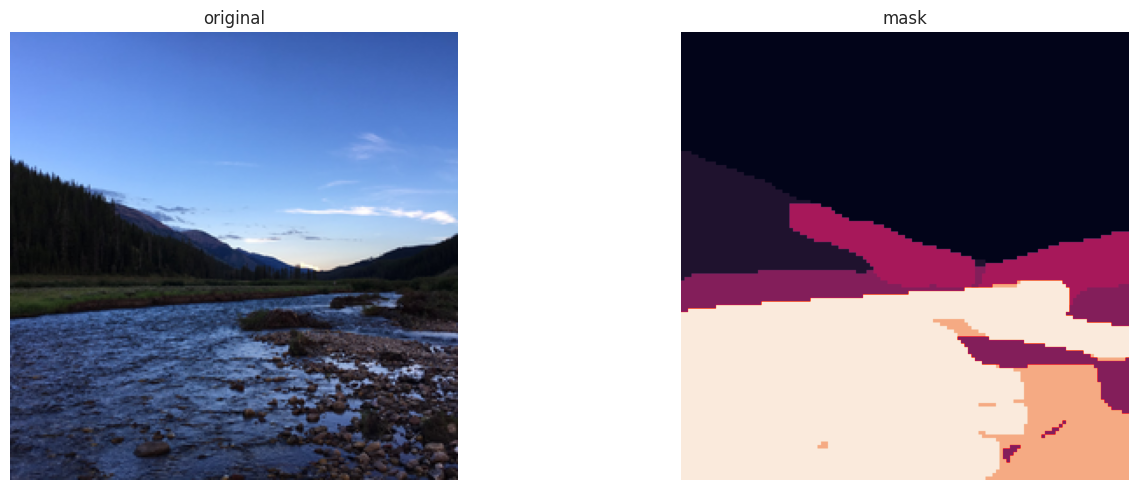

In [17]:
def visualize_process(images, titles):
    n = len(images)
    fig, ax = plt.subplots(1, n, figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax[i].imshow(image)
        ax[i].set_title(title)
        ax[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_process([image, mask], ['original', 'mask'])

In [18]:
import cv2
import numpy as np
from skimage.segmentation import slic
from skimage.filters import gabor_kernel
from scipy.ndimage import convolve
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from typing import Tuple, List

def resize(image: np.ndarray, mask: np.ndarray, scale: float = 0.5) -> Tuple[np.ndarray, np.ndarray]:
    """Resize image and mask by a scaling factor."""
    img_resized = cv2.resize(image, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_NEAREST)
    return img_resized, mask_resized

def equalize_hist(image: np.ndarray) -> np.ndarray:
    """Perform histogram equalization on a grayscale or RGB image."""
    if image.ndim == 2:
        return cv2.equalizeHist(image)
    channels = cv2.split(image)
    equalized_channels = [cv2.equalizeHist(chan) for chan in channels]
    return cv2.merge(equalized_channels)

def superpixel_segmentation(image: np.ndarray, n_segments: int = 100) -> np.ndarray:
    """Segment an image into superpixels."""
    return slic(image, n_segments=n_segments, compactness=10, start_label=1)

def extract_hist(image: np.ndarray, segments: np.ndarray, superpixel_id: int) -> np.ndarray:
    """Extract a histogram for a specific superpixel."""
    mask_segment = (segments == superpixel_id).astype(np.uint8)
    hist = cv2.calcHist([image], [0, 1, 2], mask_segment, [3, 3, 3], [0, 256, 0, 256, 0, 256])
    return hist.flatten()

def generate_gabor_filter_bank(frequency: float = 0.1, n_orientations: int = 6) -> List[np.ndarray]:
    """Generate a Gabor filter bank with specified frequency and orientations."""
    return [
        gabor_kernel(frequency, theta=theta)
        for theta in np.linspace(0, np.pi, n_orientations, endpoint=False)
    ]

def extract_gabor_features(image: np.ndarray, filter_bank: List[np.ndarray]) -> np.ndarray:
    """Apply Gabor filters to an image and collect the responses."""
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    responses = [convolve(image, np.real(kernel), mode='reflect') for kernel in filter_bank]
    return np.stack(responses, axis=-1)

def compute_superpixel_features(
    segments: np.ndarray, gabor_responses: np.ndarray
) -> np.ndarray:
    """Compute features for each superpixel using Gabor filter responses."""
    num_superpixels = segments.max()
    num_filters = gabor_responses.shape[-1]
    features = np.zeros((num_superpixels, num_filters))

    for sp_label in range(1, num_superpixels + 1):
        mask = segments == sp_label
        for f in range(num_filters):
            response = gabor_responses[..., f]
            features[sp_label - 1, f] = response[mask].mean()
    return features

def extract_features(
    images: List[np.ndarray], masks: List[np.ndarray], gabor_filter_bank: List[np.ndarray], return_segemnts: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Extract features and labels from a list of images and masks."""
    all_features, all_labels, all_segments = [], [], []
    for image, mask in zip(images, masks):
        processed_image = equalize_hist(image)
        segments = superpixel_segmentation(processed_image)
        gabor_responses = extract_gabor_features(processed_image, gabor_filter_bank)

        num_superpixels = segments.max()
        image_features = []
        superpixel_labels = []

        for sp_label in range(1, num_superpixels + 1):
            sp_mask = segments == sp_label

            # Gabor features
            gabor_features = [
                gabor_responses[..., f][sp_mask].mean()
                for f in range(gabor_responses.shape[-1])
            ]

            # Histogram features
            hist = extract_hist(processed_image, segments, sp_label)
            hist_features = [
                hist.mean(), hist.var(), skew(hist), kurtosis(hist), np.sum(hist**2)
            ]

            # Combine features
            image_features.append(gabor_features + hist_features)

            # Determine superpixel label
            pixel_labels = mask[sp_mask].flatten()
            if pixel_labels.size > 0:
                superpixel_labels.append(np.bincount(pixel_labels).argmax())
            else:
                superpixel_labels.append(-1)
            
            if return_segemnts:
                all_segments.append(segments.flatten())
        all_features.append(np.array(image_features))
        all_labels.append(np.array(superpixel_labels))

    return np.vstack(all_features), np.hstack(all_labels), 

In [19]:
gabor_filter_bank = generate_gabor_filter_bank()
features, labels = extract_features(images, masks, gabor_filter_bank)

In [20]:
features.shape, labels.shape

((1079, 11), (1079,))

In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [22]:
from thundergbm import TGBMClassifier

clf = TGBMClassifier(objective='multi:softmax', verbose=2)
clf.fit(x_train, y_train)

2024-12-11 18:49:29,126 INFO [default] #instances = 863, #features = 11
2024-12-11 18:49:29,126 INFO [default] convert csr to csc using gpu...
2024-12-11 18:49:29,139 TRACE [default] [SparseColumns::csr2csc_gpu(const DataSet&, std::vector<std::unique_ptr<SparseColumns> >&)::<lambda(int)>] [/home/zeyi/thundergbm/src/thundergbm/sparse_columns.cu:126] sorting feature values (multi-device)
2024-12-11 18:49:29,140 INFO [default] Converting csr to csc using time: 0.0137144 s
2024-12-11 18:49:29,140 INFO [default] Fast getting cut points...
2024-12-11 18:49:29,140 DEBUG [default] [aneta@unknown-host] [void unique_by_flag(SyncArray<float>&, SyncArray<int>&, int)] [/home/zeyi/thundergbm/src/thundergbm/hist_cut.cu:98] max feature value: 4.53578e+07
2024-12-11 18:49:29,140 DEBUG [default] [aneta@unknown-host] [void HistCut::get_cut_points3(SparseColumns&, int, int)] [/home/zeyi/thundergbm/src/thundergbm/hist_cut.cu:172] --->>>>  cut points value: [177.158,153.361,142.501,138.972,132.819,122.058,1

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2024-12-11 18:49:32,293 DEBUG [default] [aneta@unknown-host] [virtual void TreeBuilder::split_point_all_reduce(int)] [/home/zeyi/thundergbm/src/thundergbm/builder/tree_builder.cu:142] global best split point = [0.637755/0/31/-2.143470/5.872491,0.876433/4/32/-0.982097/2.286916,0.297183/0/33/-1.805539/2.985301,0.554447/10/34/-0.751567/1.884478,0.598051/7/35/-0.501534/1.065571,0/0/36/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/0/51/0.000000/0.000000,0/0/52/0.000000/0.000000,0.226701/7/53/-0.609962/1.415482,0/0/54/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000000,0/-1/-1/0.000000/0.000

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [23]:
y_pred = clf.predict(x_test)

2024-12-11 18:49:34,132 INFO [default] #instances = 216, #features = 11
2024-12-11 18:49:34,147 INFO [default] use shared memory to predict
2024-12-11 18:49:34,147 INFO [default] Done y transform size is 216


In [24]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.47685185185185186

282x29

<Axes: >

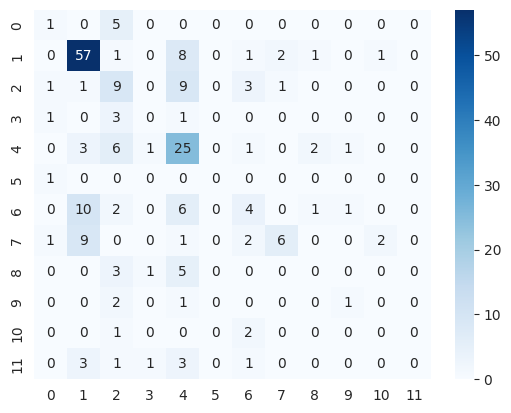

In [25]:
from sklearn.metrics import jaccard_score, confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')